# Import

In [22]:
from pandas_data_reader_service_core.modules.finam.search_service import Search, Market
from pandas_data_reader_service_core.modules.finam.stock_info import FinamStockInfo
from pandas_data_reader_service_core.service import PandasDataReaderService as pdrs, StockInfo, TimeFrame
from datetime import date
import seaborn as sns
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

In [23]:
stock = "EURUSD"
market = Market.CURRENCIES_WORLD
vol = "V"
price_type = "PriceType"
price_value = "Price"
middle_price = "MidPrice"
volume_price_col_name = "VolumePrice"
log_aggr_volume_price_col_name = "LogAggrVolumePrice"
nlog_aggr_volume_price_col_name = "NLogAggrVolumePrice"
aggr_volume_price = "AggrVolumePrice"

# Load data

In [24]:
stock_list = Search.by_code(stock, market)
stock_list

,name,code,market
id,,,
83,Eur/Usd,EURUSD,5


In [25]:
stock_info = StockInfo.init_for_Finam(FinamStockInfo(stock_list.index[0]))
print(stock_info)

Source StockSource.Finam source StockInfo Market 5 code EURUSD index 83


In [26]:
date_from = date(2015,1,1)
date_till = date(2020,2,1)
tf = TimeFrame.HOURLY

In [27]:
data_df = pdrs().get(stock=stock_info,  date_from=date_from,date_to=date_till,time_frame=tf,short_col_name=True)
data_df

,O,H,L,C,V
DT,,,,,
2015-01-01 00:00:00,1.20986,1.21079,1.20970,1.21006,26264
2015-01-01 01:00:00,1.21005,1.21037,1.20960,1.21009,15605
2015-01-01 02:00:00,1.21016,1.21024,1.20950,1.21005,14092
2015-01-01 03:00:00,1.21003,1.21008,1.20948,1.20970,10195
2015-01-01 04:00:00,1.20971,1.21000,1.20948,1.20959,136
...,...,...,...,...,...
2020-01-31 21:00:00,1.10828,1.10836,1.10760,1.10799,69886
2020-01-31 22:00:00,1.10800,1.10902,1.10780,1.10894,78526
2020-01-31 23:00:00,1.10891,1.10919,1.10830,1.10904,56848


# Prepare data

## Middle price

In [28]:
data_df[middle_price] = (data_df["C"] + data_df["O"])/2
data_df

,O,H,L,C,V,MidPrice
DT,,,,,,
2015-01-01 00:00:00,1.20986,1.21079,1.20970,1.21006,26264,1.209960
2015-01-01 01:00:00,1.21005,1.21037,1.20960,1.21009,15605,1.210070
2015-01-01 02:00:00,1.21016,1.21024,1.20950,1.21005,14092,1.210105
2015-01-01 03:00:00,1.21003,1.21008,1.20948,1.20970,10195,1.209865
2015-01-01 04:00:00,1.20971,1.21000,1.20948,1.20959,136,1.209650
...,...,...,...,...,...,...
2020-01-31 21:00:00,1.10828,1.10836,1.10760,1.10799,69886,1.108135
2020-01-31 22:00:00,1.10800,1.10902,1.10780,1.10894,78526,1.108470
2020-01-31 23:00:00,1.10891,1.10919,1.10830,1.10904,56848,1.108975


## Column into rows

In [29]:
prepared_df = data_df.melt(id_vars=[vol], 
                            var_name=price_type, 
                            value_name=price_value)
len(prepared_df)

163430

In [30]:
prepared_df = prepared_df.groupby([price_type, price_value]).sum().reset_index()
print(len(prepared_df))
prepared_df

66650


,PriceType,Price,V
0,C,1.03558,108744
1,C,1.03696,101939
2,C,1.03713,102614
3,C,1.03739,142222
4,C,1.03766,107396
...,...,...,...
66645,O,1.25380,49017
66646,O,1.25381,97892
66647,O,1.25392,94039
66648,O,1.25485,52679


## Разделяем на фичи

In [31]:
prepared_df = prepared_df[prepared_df[price_type]==middle_price][[price_value, vol]]
prepared_df

,Price,V
32390,1.036265,101939
32391,1.036705,108744
32392,1.037040,102614
32393,1.037400,107396
32394,1.038325,99383
...,...,...
53247,1.253310,97892
53248,1.253860,49017
53249,1.254340,54616
53250,1.254370,94039


## Create VolumePriceMult

In [32]:
prepared_df[volume_price_col_name] = prepared_df[price_value] * prepared_df[vol]
prepared_df

,Price,V,VolumePrice
32390,1.036265,101939,105635.817835
32391,1.036705,108744,112735.448520
32392,1.037040,102614,106414.822560
32393,1.037400,107396,111412.610400
32394,1.038325,99383,103191.853475
...,...,...,...
53247,1.253310,97892,122689.022520
53248,1.253860,49017,61460.455620
53249,1.254340,54616,68507.033440
53250,1.254370,94039,117959.700430


## Group aggregation

In [33]:
from src.SupportLines.GroupAggregator import GroupAggregator

In [34]:
gragr = GroupAggregator(0.015)
prepared_df[aggr_volume_price] = gragr.aggregate(prepared_df[price_value], prepared_df[volume_price_col_name])
prepared_df

,Price,V,VolumePrice,AggrVolumePrice
32390,1.036265,101939,105635.817835,2.623279e+07
32391,1.036705,108744,112735.448520,2.749664e+07
32392,1.037040,102614,106414.822560,2.813979e+07
32393,1.037400,107396,111412.610400,2.967458e+07
32394,1.038325,99383,103191.853475,3.370721e+07
...,...,...,...,...
53247,1.253310,97892,122689.022520,6.401065e+07
53248,1.253860,49017,61460.455620,6.203610e+07
53249,1.254340,54616,68507.033440,5.991519e+07
53250,1.254370,94039,117959.700430,5.974123e+07


## Логарифмическая трансформация

In [35]:
from src.Tool.DataPreparation import normilize, log_tr

In [36]:
prepared_df[log_aggr_volume_price_col_name] = log_tr(prepared_df[aggr_volume_price])
prepared_df[nlog_aggr_volume_price_col_name] = normilize(prepared_df[log_aggr_volume_price_col_name])
prepared_df

,Price,V,VolumePrice,AggrVolumePrice,LogAggrVolumePrice,NLogAggrVolumePrice
32390,1.036265,101939,105635.817835,2.623279e+07,0.000000,0.000000
32391,1.036705,108744,112735.448520,2.749664e+07,14.049676,0.680269
32392,1.037040,102614,106414.822560,2.813979e+07,14.461044,0.700186
32393,1.037400,107396,111412.610400,2.967458e+07,15.051502,0.728776
32394,1.038325,99383,103191.853475,3.370721e+07,15.826997,0.766324
...,...,...,...,...,...,...
53247,1.253310,97892,122689.022520,6.401065e+07,17.447234,0.844774
53248,1.253860,49017,61460.455620,6.203610e+07,17.393551,0.842175
53249,1.254340,54616,68507.033440,5.991519e+07,17.332486,0.839218
53250,1.254370,94039,117959.700430,5.974123e+07,17.327308,0.838968


In [37]:
prepared_df.describe()

,Price,V,VolumePrice,AggrVolumePrice,LogAggrVolumePrice,NLogAggrVolumePrice
count,20862.000000,20862.000000,20862.000000,2.086200e+04,20862.000000,20862.000000
mean,1.131796,100850.069984,113839.564578,5.181807e+08,19.810768,0.959214
std,0.047841,75495.292883,84788.600615,2.717776e+08,0.717260,0.034729
min,1.036265,1.000000,1.044920,2.623279e+07,0.000000,0.000000
25%,1.098201,46690.500000,52843.621880,3.035907e+08,19.440819,0.941301
50%,1.125630,83295.000000,94306.540812,4.493769e+08,19.863223,0.961754
75%,1.164894,131485.500000,148965.258652,7.925982e+08,20.457170,0.990512
max,1.254870,710226.000000,806919.718770,9.585026e+08,20.653133,1.000000


## Исключение выбросов

In [38]:
from src.Tool.DataPreparation import handle_outlier
handler = handle_outlier()

In [39]:
handler.replace(prepared_df[log_aggr_volume_price_col_name])
prepared_df[log_aggr_volume_price_col_name] = prepared_df[log_aggr_volume_price_col_name] - prepared_df[log_aggr_volume_price_col_name].min()
prepared_df

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Price,V,VolumePrice,AggrVolumePrice,LogAggrVolumePrice,NLogAggrVolumePrice
32390,1.036265,101939,105635.817835,2.623279e+07,0.0,0.000000
32391,1.036705,108744,112735.448520,2.749664e+07,0.0,0.680269
32392,1.037040,102614,106414.822560,2.813979e+07,0.0,0.700186
32393,1.037400,107396,111412.610400,2.967458e+07,0.0,0.728776
32394,1.038325,99383,103191.853475,3.370721e+07,0.0,0.766324
...,...,...,...,...,...,...
53247,1.253310,97892,122689.022520,6.401065e+07,0.0,0.844774
53248,1.253860,49017,61460.455620,6.203610e+07,0.0,0.842175
53249,1.254340,54616,68507.033440,5.991519e+07,0.0,0.839218
53250,1.254370,94039,117959.700430,5.974123e+07,0.0,0.838968


In [40]:
prepared_df.describe()

,Price,V,VolumePrice,AggrVolumePrice,LogAggrVolumePrice,NLogAggrVolumePrice
count,20862.000000,20862.000000,20862.000000,2.086200e+04,20862.000000,20862.000000
mean,1.131796,100850.069984,113839.564578,5.181807e+08,2.157000,0.959214
std,0.047841,75495.292883,84788.600615,2.717776e+08,0.686657,0.034729
min,1.036265,1.000000,1.044920,2.623279e+07,0.000000,0.000000
25%,1.098201,46690.500000,52843.621880,3.035907e+08,1.781831,0.941301
50%,1.125630,83295.000000,94306.540812,4.493769e+08,2.204235,0.961754
75%,1.164894,131485.500000,148965.258652,7.925982e+08,2.798181,0.990512
max,1.254870,710226.000000,806919.718770,9.585026e+08,2.994144,1.000000


# Visualize

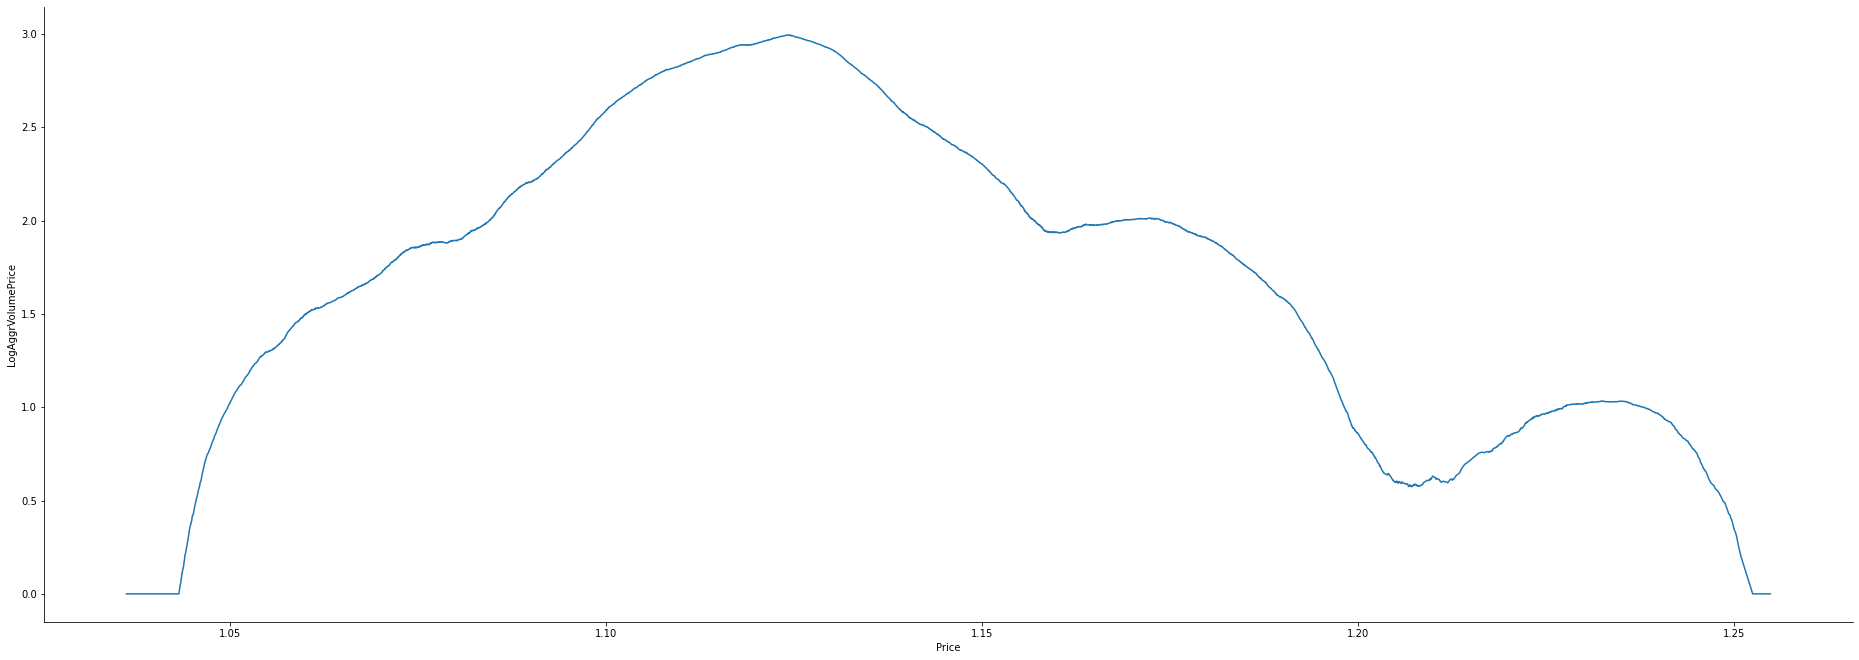

In [43]:
g = sns.relplot(x=price_value, y=log_aggr_volume_price_col_name, kind="line", data=prepared_df)
g.figure.set_size_inches(30,10)